<br />

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [14]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [19]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


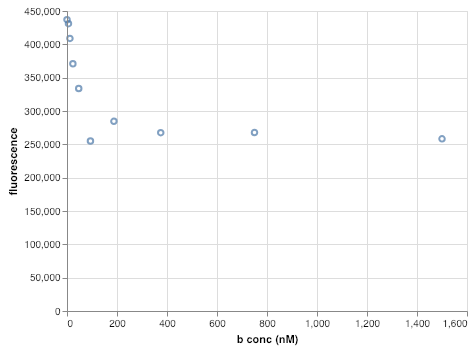

In [20]:
alt.Chart(df).mark_point().encode(
    x = alt.X("b conc (nM)"),
    y = alt.Y("fluorescence"))

LOL I wonder if there are any outliers

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} = \text{Norm}(F(c_a^0), \sigma).$$ 

In [26]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

$K_d$ ~ lognorm(1, 3) Given our (limited) knowledge of dissociation constants, we expect $K_d$ to be very small, but do no know the order of magnitude, so we will use a log-normal distribution

$\hat{f}_0$ ~ Norm(500000, 50000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000, so we will choose a distribution with a wide variation at the top of this scale

$\hat{f}_q$ ~ Norm(50000, 5000) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution an order of magnitude smaller than that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, .5): We expect a variability in measurement of about .1, and to vary from that by about .1. 

Additionally, we know that 
$c_a^0$ = 50 nM

In [41]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_976996489ad35fa6c358b48f515b21fc NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmpy6cbzwn_/stanfit4anon_model_976996489ad35fa6c358b48f515b21fc_2759271549440924742.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [48]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)

In [49]:
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)
df_gen

,chain,chain_idx,warmup,Kd,f0,fq,sigma,ca,F[1],F[2],...,likelihood[2],likelihood[3],likelihood[4],likelihood[5],likelihood[6],likelihood[7],likelihood[8],likelihood[9],likelihood[10],lp__
0,1,1,0,0.431689,449837.455597,46646.676370,1957.571680,50.0,2.338334e+06,2.344758e+06,...,2.351017e+06,2.360683e+06,2.396324e+06,2.529567e+06,4.824042e+06,1.318652e+07,1.781705e+07,2.015500e+07,2.249620e+07,0.0
1,1,2,0,1.161343,557114.177461,50514.147753,9816.163279,50.0,2.545978e+06,2.567657e+06,...,2.582631e+06,2.622258e+06,2.741684e+06,3.158484e+06,6.921194e+06,1.647048e+07,2.209482e+07,2.496421e+07,2.786838e+07,0.0
2,1,3,0,0.051753,516274.567273,49161.422263,3716.119571,50.0,2.458905e+06,2.459798e+06,...,2.461797e+06,2.470352e+06,2.468044e+06,2.483210e+06,4.217611e+06,1.488213e+07,2.034774e+07,2.307684e+07,2.581757e+07,0.0
3,1,4,0,0.451476,508094.810034,42535.185698,3367.090977,50.0,2.134005e+06,2.141762e+06,...,2.148867e+06,2.157824e+06,2.198170e+06,2.369980e+06,5.045458e+06,1.467417e+07,2.000756e+07,2.270498e+07,2.540378e+07,0.0
4,1,5,0,1.232923,519715.551247,43314.643239,2778.356874,50.0,2.185968e+06,2.207608e+06,...,2.211658e+06,2.259855e+06,2.373721e+06,2.801279e+06,6.380815e+06,1.529649e+07,2.057699e+07,2.326721e+07,2.598326e+07,0.0
5,1,6,0,3.071546,486758.352922,51224.949885,4423.715678,50.0,2.607276e+06,2.656355e+06,...,2.660455e+06,2.761862e+06,3.037149e+06,3.896814e+06,7.969783e+06,1.510955e+07,1.960602e+07,2.194799e+07,2.434221e+07,0.0
6,1,7,0,36.618567,454029.701919,49315.959444,9193.953826,50.0,2.963834e+06,3.468377e+06,...,3.461311e+06,4.490411e+06,6.478599e+06,9.965883e+06,1.428195e+07,1.787056e+07,2.014012e+07,2.137701e+07,2.269119e+07,0.0
7,1,8,0,4.865257,483430.709361,48980.118743,4055.637959,50.0,2.521641e+06,2.598870e+06,...,2.602067e+06,2.770018e+06,3.174322e+06,4.430395e+06,8.851185e+06,1.541230e+07,1.963605e+07,2.186532e+07,2.416449e+07,0.0
8,1,9,0,2264.987871,435907.628807,53550.931450,4948.259063,50.0,1.423938e+07,1.709844e+07,...,1.709878e+07,1.911428e+07,2.036445e+07,2.105948e+07,2.141613e+07,2.161316e+07,2.169499e+07,2.174410e+07,2.180407e+07,0.0
9,1,10,0,0.023919,497246.537892,54754.056831,5106.017730,50.0,2.738068e+06,2.738459e+06,...,2.732543e+06,2.751547e+06,2.741728e+06,2.754759e+06,4.259248e+06,1.448758e+07,1.968465e+07,2.226747e+07,2.486647e+07,0.0


In [54]:
cols = ["likelihood[1]", "likelihood[2]", "likelihood[3]", "likelihood[4]", "likelihood[5]",
        "likelihood[6]", "likelihood[7]", "likelihood[8]", "likelihood[9]", "likelihood[10]"]

In [72]:
data

{'N': 10,
 'cb': array([1500.      ,  750.      ,  375.      ,  187.5     ,   93.75    ,
          46.875   ,   23.4375  ,   11.71875 ,    5.859375,    0.      ])}

In [79]:
df_gen_fl = df_gen[cols]
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    



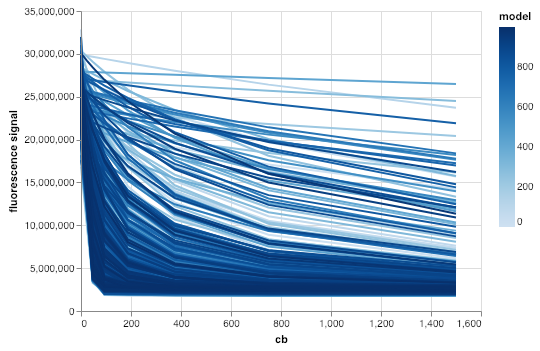

In [82]:
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model'))
    